# Threshold Sensitivity Analysis

This notebook analyzes the effect of the reasoning threshold on the model's performance on the validation set (GSM8K-Val).

It reads the pre-computed results from `leaderboard_thinkbrake.json` and compares them against the **Rollout (Baseline)** results from `leaderboard_rollout.json`.

In [ ]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plot style
sns.set_theme(style="whitegrid")

# Constants
OUTPUT_DIR = Path("../outputs")
THINKBRAKE_FILE = OUTPUT_DIR / "leaderboard_thinkbrake.json"
ROLLOUT_FILE = OUTPUT_DIR / "leaderboard_rollout.json"

MODEL_NAME = "Qwen/Qwen3-4B-Thinking-2507"
CATEGORY = "gsm8k-val"

In [2]:
def load_leaderboard(file_path):
    if not file_path.exists():
        print(f"Warning: {file_path} not found.")
        return {}
    with open(file_path, "r", encoding="utf-8") as f:
        return json.load(f)


thinkbrake_data = load_leaderboard(THINKBRAKE_FILE)
rollout_data = load_leaderboard(ROLLOUT_FILE)


# Helper to find model data handling potnetial name variations (slash vs underscore)
def get_model_data(data, model_name):
    if model_name in data:
        return data[model_name]

    # Try underscore replacement
    alt_name = model_name.replace("/", "_")
    if alt_name in data:
        return data[alt_name]

    print(f"Model {model_name} (or {alt_name}) not found in data.")
    return None


tb_model_data = get_model_data(thinkbrake_data, MODEL_NAME)
ro_model_data = get_model_data(rollout_data, MODEL_NAME)

print(f"Loaded data for: {MODEL_NAME}")
if tb_model_data and CATEGORY in tb_model_data:
    print(f"Found ThinkBrake results for {CATEGORY}")
else:
    print(f"No ThinkBrake results for {CATEGORY}")

if ro_model_data and CATEGORY in ro_model_data:
    print(f"Found Rollout results for {CATEGORY}")
else:
    print(f"No Rollout results for {CATEGORY}")

Loaded data for: Qwen/Qwen3-4B-Thinking-2507
Found ThinkBrake results for gsm8k-val
Found Rollout results for gsm8k-val


In [3]:
plot_data = []

rollout_baseline = None
if ro_model_data and CATEGORY in ro_model_data:
    rollout_baseline = ro_model_data[CATEGORY]

# Process ThinkBrake Data
if tb_model_data and CATEGORY in tb_model_data:
    cat_data = tb_model_data[CATEGORY]
    for key, stats in cat_data.items():
        if key.startswith("threshold_"):
            try:
                t_val = float(key.replace("threshold_", ""))

                # Calculate Token Reduction vs Rollout Baseline if available
                token_reduction = None
                if rollout_baseline:
                    base_tokens = rollout_baseline.get("avg_token_length", 0)
                    curr_tokens = stats["avg_token_length"]
                    if base_tokens > 0:
                        token_reduction = (
                            (base_tokens - curr_tokens) / base_tokens * 100
                        )

                plot_data.append(
                    {
                        "threshold": t_val,
                        "accuracy": stats["accuracy"],
                        "avg_token_length": stats["avg_token_length"],
                        "token_reduction": token_reduction,
                        "type": "ThinkBrake",
                    }
                )
            except ValueError:
                continue

df = pd.DataFrame(plot_data)
if not df.empty:
    df = df.sort_values("threshold")
    print(df.head())
else:
    print("No data available for plotting.")

   threshold  accuracy  avg_token_length  token_reduction        type
0       0.05      95.2          1175.952        16.561276  ThinkBrake
1       0.10      95.4          1183.206        16.046574  ThinkBrake
2       0.25      93.6          1154.402        18.090339  ThinkBrake
3       0.50      94.5          1196.565        15.098697  ThinkBrake
4       1.00      95.0          1138.555        19.214750  ThinkBrake


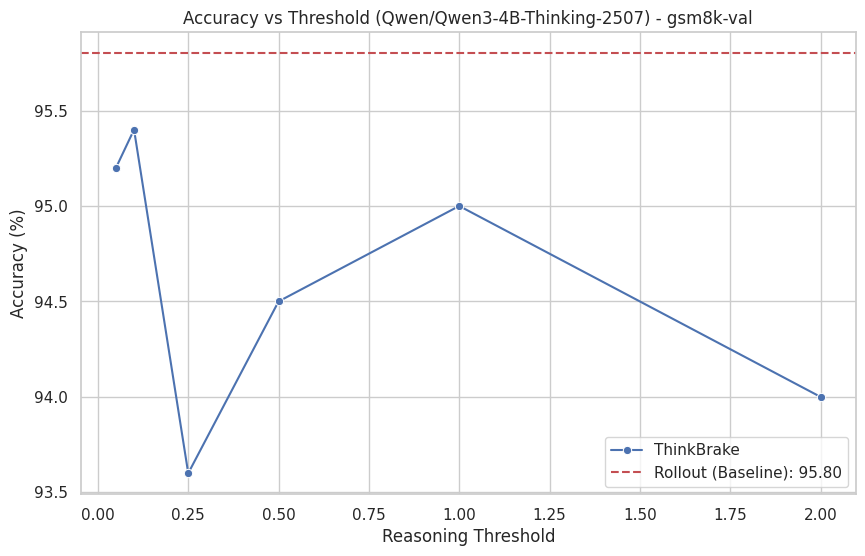

In [4]:
def plot_metric(df, metric, title, ylabel, baseline_stats=None, baseline_key=None):
    if df.empty or metric not in df.columns:
        print(f"No data to plot for {metric}.")
        return

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="threshold", y=metric, marker="o", label="ThinkBrake")

    # Add Rollout Baseline if requested and available
    if baseline_stats and baseline_key:
        baseline_val = baseline_stats[baseline_key]
        plt.axhline(
            y=baseline_val,
            color="r",
            linestyle="--",
            label=f"Rollout (Baseline): {baseline_val:.2f}",
        )

    plt.title(title)
    plt.xlabel("Reasoning Threshold")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot Accuracy
plot_metric(
    df,
    "accuracy",
    f"Accuracy vs Threshold ({MODEL_NAME}) - {CATEGORY}",
    "Accuracy (%)",
    rollout_baseline,
    "accuracy",
)

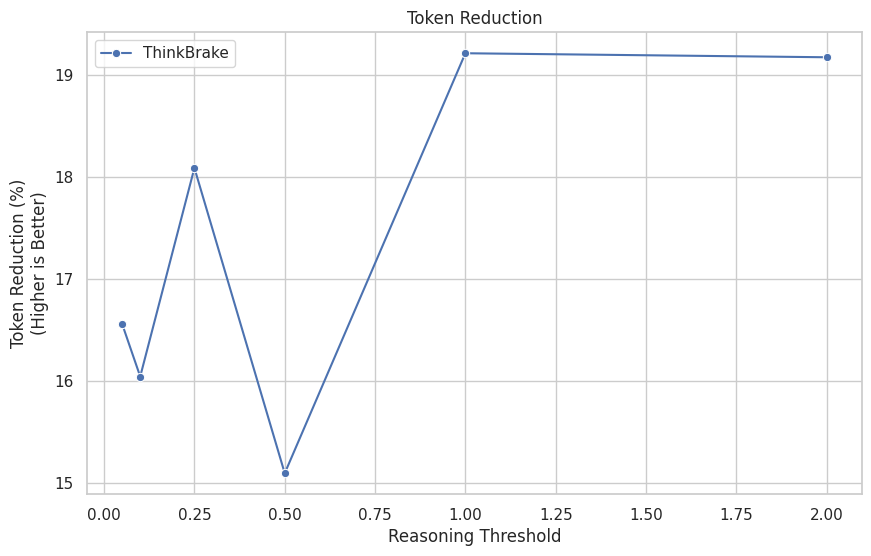

In [5]:
plot_metric(
    df,
    "token_reduction",
    f"Token Reduction",
    "Token Reduction (%)\n(Higher is Better)",
    None,
    None,
)